# Gathering data

In [1]:
from fastai.vision.widgets import *
from fastai.vision.all import *

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'fa628bcbbf504c87bf6525ab584a1d48')

In [5]:
results = search_images_bing(key, 'dog')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
dog_types = 'Goldendoodle', 'Chihuahua', 'Shih Tzu'
path = Path('dogs')

In [7]:
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#431) [Path('dogs/Goldendoodle/774023b5-2388-4caa-9d9f-ce98fbf0f36b.jpg'),Path('dogs/Goldendoodle/6edcb440-41d0-49a1-9b37-2d120c4cf70a.jpg'),Path('dogs/Goldendoodle/22a05557-d9a4-4f3a-8d28-c6dd9e9e0306.jpg'),Path('dogs/Goldendoodle/07800519-7d14-472f-8504-47f79b28c658.jpg'),Path('dogs/Goldendoodle/0b5b9a56-6839-4b23-8d37-3fbae00bef99.jpg'),Path('dogs/Goldendoodle/fd1dee40-67ea-4256-910c-a2a3edd7a9be.png'),Path('dogs/Goldendoodle/0f7e6867-cea9-492c-b9c1-9889167a4c27.jpg'),Path('dogs/Goldendoodle/9e3af534-bb16-4d10-bf26-6efe883b4c6e.jpg'),Path('dogs/Goldendoodle/316dded8-1203-4c9e-a44c-9ee54b90ac2a.jpg'),Path('dogs/Goldendoodle/ee6fa6f0-7641-4005-8315-7c5dc8e415b1.JPG')...]

# Clean data

In [9]:
failed = verify_images(fns)
failed

(#1) [Path('dogs/Goldendoodle/0447a2da-0c25-43ee-b4ea-3eaad2ca125d.jpg')]

In [10]:
failed.map(Path.unlink);

# Dataloader

In [11]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = dogs.dataloaders(path)

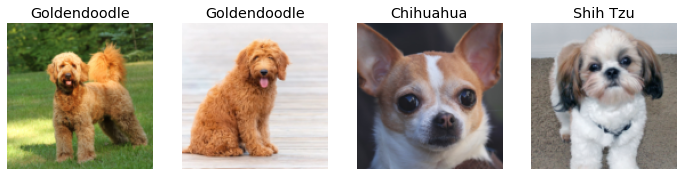

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

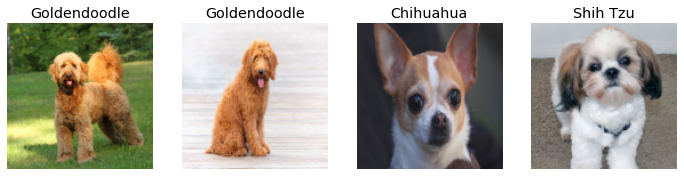

In [14]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

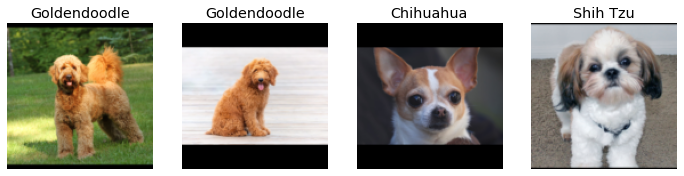

In [15]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

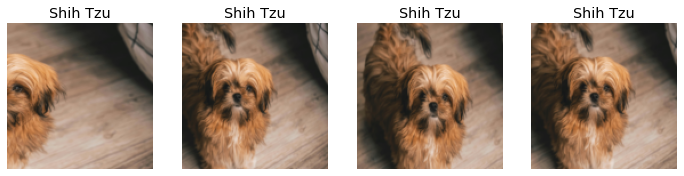

In [16]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [17]:
# dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
# dls = dogs.dataloaders(path)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
# dogs = dogs.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())
# dls = dogs.dataloaders(path)

# Training Your Model, and Using It to Clean Your Data

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/minjae/opt/anaconda3/lib/python3.9/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,1.733960,0.124464,0.034884,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.431380,0.133377,0.046512,00:13
1,0.303147,0.096585,0.046512,00:13
2,0.209622,0.082387,0.034884,00:13
3,0.161310,0.079151,0.034884,00:13


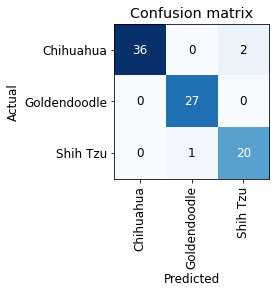

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

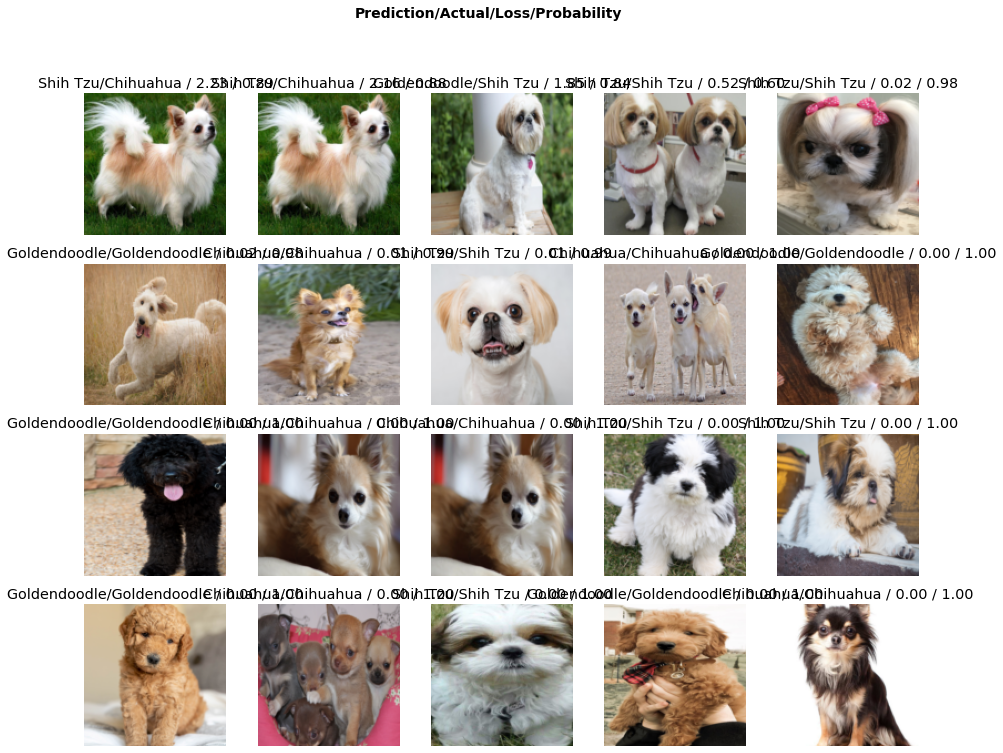

In [21]:
interp.plot_top_losses(20, nrows=4)

In [22]:
cleaner = ImageClassifierCleaner(learn, max_n=150)
cleaner

In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Save model

In [24]:
learn.export('dog.pkl')

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('dog.pkl')]

In [26]:
learn = load_learner('dog.pkl')